# Independence of mechanism

The idea is that the parameters of causal Markov kernel for a node should be independent of that nodes causes

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyro.poutine import trace
from pprint import pprint
import math
#from matplotlib.pyplot import hist
#true model
from matplotlib import pyplot as plt
from torch import nn


In [2]:
#Y_mean = beta * X / (1 + beta * X)
def transmitter(n):
    alpha =  2.0
    beta = 3.0
    with pyro.plate('data', n):
        X = pyro.sample('X', dist.Normal(alpha, .10))
        #Y_mean = nn.Sigmoid()(beta * X)
        Y_mean = beta * X / (1 + beta * X)
        Y = pyro.sample('Y', dist.Normal(Y_mean,.10))
    return X,Y
transmitter(10)

def true_model(n):
    alpha = pyro.sample('alpha', dist.Uniform(2.0 - 3.0, 2.0 + 3.0))
    beta = pyro.sample('beta', dist.Uniform(3.0 - 3.0, 3.0 + 3.0))
    with pyro.plate('data', n):
        X = pyro.sample('X', dist.Normal(alpha,1.0))
        #Y_mean = nn.Sigmoid()(beta * X)
        Y_mean = beta * X / (1 + beta * X)
        Y = pyro.sample('Y', dist.Normal(Y_mean,1.0))
    return Y

def wrong_model(n):
    alpha = pyro.sample('alpha',  dist.Uniform(2.0 - 3.0, 2.0 + 3.0))
    beta = pyro.sample('beta', dist.Uniform(3.0 - 3.0, 3.0 + 3.0))
    with pyro.plate('data', n):
        Y = pyro.sample('Y', dist.Normal(alpha,1.0))
        #X_mean = nn.Sigmoid()(beta * Y)
        X_mean = beta * Y / (1 + beta * Y)
        X = pyro.sample('X', dist.Normal(X_mean,1.0))
    return X



We want to calculate $P(alpha|X,Y)$ and P(beta|X,Y). First I will try the SVI approach and define a guide, second I will try the HMC approach. 

In [3]:
n = 1000
x_data, y_data = transmitter(n)
conditioned_true_model = pyro.condition(true_model, data = {"X":x_data, "Y":y_data})
conditioned_wrong_model = pyro.condition(wrong_model, data = {"X":x_data, "Y":y_data})
#conditioned_true_model(10)

In [4]:
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC, NUTS
from pyro.infer import EmpiricalMarginal
import matplotlib.pyplot as plt

alpha_prior = 2.
nuts_kernel = NUTS(conditioned_true_model, adapt_step_size=True)
posterior = MCMC(nuts_kernel, 
                 num_samples=1000, 
                 warmup_steps=50)
posterior.run(n) #gives list of tuples of alpha and beta
samples = posterior.get_samples() #dic keys are alpha and beta


Sample: 100%|██████████| 1050/1050 [00:13, 75.30it/s, step size=7.02e-01, acc. prob=0.856]


(array([  1.,   3.,  40., 124., 218., 266., 185., 125.,  31.,   7.]),
 array([1.8883235, 1.9096448, 1.9309661, 1.9522873, 1.9736086, 1.9949299,
        2.016251 , 2.0375724, 2.0588937, 2.080215 , 2.1015363],
       dtype=float32),
 <a list of 10 Patch objects>)

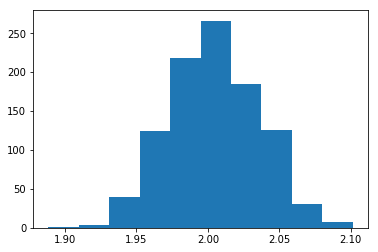

In [5]:
plt.hist(samples['alpha'])

(array([ 23., 122., 191., 214., 156., 128.,  61.,  58.,  28.,  19.]),
 array([1.6387768, 2.0659957, 2.4932146, 2.9204338, 3.3476527, 3.7748716,
        4.2020907, 4.6293097, 5.0565286, 5.4837475, 5.9109664],
       dtype=float32),
 <a list of 10 Patch objects>)

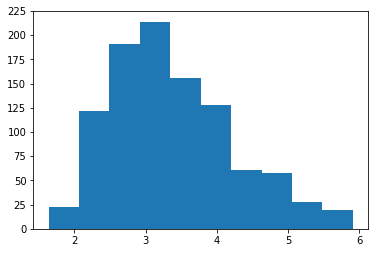

In [6]:
plt.hist(samples['beta'])

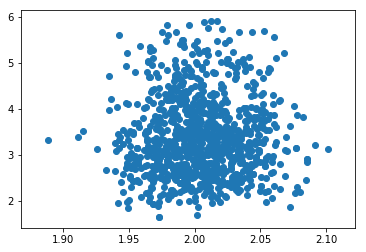

In [7]:
plt.scatter(samples['alpha'], samples['beta'])

In [8]:
hmc_kernel = NUTS(conditioned_wrong_model, adapt_step_size=True)
posterior2 = MCMC(hmc_kernel, 
                 num_samples=1000, 
                 warmup_steps=50)
posterior2.run(n) #gives list of tuples of alpha and beta
samples2 = posterior2.get_samples() #dic keys are alpha and beta


Sample: 100%|██████████| 1050/1050 [02:00,  8.68it/s, step size=1.09e-02, acc. prob=0.954]


(array([  2.,  17.,  54., 139., 241., 238., 185.,  94.,  24.,   6.]),
 array([0.7461513, 0.7667667, 0.7873821, 0.8079975, 0.8286129, 0.8492283,
        0.8698437, 0.8904591, 0.9110745, 0.9316899, 0.9523053],
       dtype=float32),
 <a list of 10 Patch objects>)

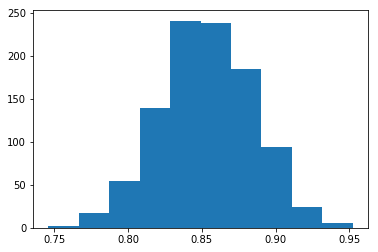

In [9]:
plt.hist(samples2['alpha'])


(array([  7.,  14.,  18.,  11.,  43.,  51., 114., 162., 234., 346.]),
 array([5.823752 , 5.841371 , 5.85899  , 5.87661  , 5.894229 , 5.911848 ,
        5.929467 , 5.9470863, 5.964706 , 5.982325 , 5.999944 ],
       dtype=float32),
 <a list of 10 Patch objects>)

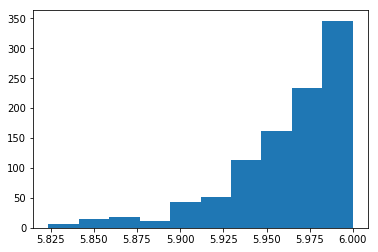

In [10]:
plt.hist(samples2['beta'])

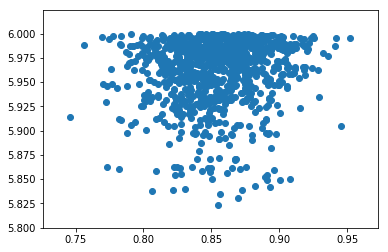

In [11]:
plt.scatter(samples2['alpha'], samples2['beta'])